# Setup

In [1]:
import os
import torch
import torch.nn as nn
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO
import torchvision.transforms as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import torchvision.transforms.functional as VF
from torch.nn import functional as F
import wandb
from itertools import cycle


In [2]:
COCO_PATH = "../../data/coco/"
IMG_DIR_TRAIN = os.path.join(COCO_PATH, "images/train2017")
IMG_DIR_VAL = os.path.join(COCO_PATH, "images/val2017")
ANN_FILE_TRAIN = os.path.join(COCO_PATH, "annotations/instances_train2017.json")
ANN_FILE_VAL = os.path.join(COCO_PATH, "annotations/instances_val2017.json")

GRID_ROWS = 6
GRID_COLS = 6
MAX_BOXES_PER_CELL = 2
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

DS_PERCENT = (0.1, 0.1, 0.1)

# Functions

## Data

In [3]:
class CustomTransform:
    def __init__(self, size=IMAGE_SIZE):
        self.transform = T.Compose([
            T.Resize(size),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __call__(self, image, target):
        return self.transform(image), target

In [4]:
class CocoBBoxDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self.coco = COCO(ann_file)
        self._transforms = transforms
        
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        orig_w, orig_h = img.size
        
        anns = []
        for obj in target:
            if obj['category_id'] == 1:  # Only humans
                anns.append(obj)
                
        if self._transforms:
            img, _ = self._transforms(img, None)
            
        # Create target tensor [GRID_ROWS, GRID_COLS, MAX_BOXES_PER_CELL, 5]
        target_tensor = torch.zeros(GRID_ROWS, GRID_COLS, MAX_BOXES_PER_CELL, 5)
        
        for ann in anns:
            bbox = ann['bbox']  # [x, y, w, h]
            # Scale to image size
            x = bbox[0] * (IMAGE_SIZE[0] / orig_w)
            y = bbox[1] * (IMAGE_SIZE[1] / orig_h)
            w = bbox[2] * (IMAGE_SIZE[0] / orig_w)
            h = bbox[3] * (IMAGE_SIZE[1] / orig_h)
            
            # Convert to center coordinates
            x_center = x + w/2
            y_center = y + h/2
            
            # Find grid cell
            cell_i = min(int(y_center * GRID_ROWS / IMAGE_SIZE[1]), GRID_ROWS-1)
            cell_j = min(int(x_center * GRID_COLS / IMAGE_SIZE[0]), GRID_COLS-1)
            
            # Normalize to cell
            cell_w = IMAGE_SIZE[0] / GRID_COLS
            cell_h = IMAGE_SIZE[1] / GRID_ROWS
            x_cell = (x_center - cell_j * cell_w) / cell_w
            y_cell = (y_center - cell_i * cell_h) / cell_h
            w_norm = w / IMAGE_SIZE[0]
            h_norm = h / IMAGE_SIZE[1]
            
            # Find empty slot
            for k in range(MAX_BOXES_PER_CELL):
                if target_tensor[cell_i, cell_j, k, 4] == 0:  # Check if slot is empty
                    target_tensor[cell_i, cell_j, k] = torch.tensor([x_cell, y_cell, w_norm, h_norm, 1.0])
                    break
                    
        return img, target_tensor
    

## Model

In [5]:
MODEL_NAME = "BBoxModelYOLO"

class BBoxModel(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Output: (B, 512, H/32, W/32)
        self.conv = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.upsample = nn.Upsample(size=(GRID_ROWS, GRID_COLS), mode='bilinear', align_corners=False)
        self.head = nn.Conv2d(128, MAX_BOXES_PER_CELL * 5, kernel_size=1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.conv(x)
        x = self.upsample(x)
        x = self.head(x)
        x = x.permute(0, 2, 3, 1)
        x = x.view(x.size(0), GRID_ROWS, GRID_COLS, MAX_BOXES_PER_CELL, 5)
        return x


## Utilities

In [6]:
def box_iou(box1, box2):
    """
    Compute IoU between two sets of boxes (N, 4) and (M, 4)
    box = [x1, y1, x2, y2]
    """
    def area(box):
        return (box[:, 2] - box[:, 0]) * (box[:, 3] - box[:, 1])
    
    area1 = area(box1)
    area2 = area(box2)
    
    lt = torch.max(box1[:, None, :2], box2[:, :2])  # top-left
    rb = torch.min(box1[:, None, 2:], box2[:, 2:])  # bottom-right
    
    wh = (rb - lt).clamp(min=0)  # (N, M, 2)
    inter = wh[:, :, 0] * wh[:, :, 1]  # (N, M)
    
    union = area1[:, None] + area2 - inter
    return inter / union


In [7]:
def non_max_suppression(boxes, scores, iou_threshold=0.5):
    """
    boxes: (N, 4) in x1,y1,x2,y2
    scores: (N,)
    """
    keep = []
    idxs = scores.argsort(descending=True)

    while idxs.numel() > 0:
        i = idxs[0]
        keep.append(i.item())
        if idxs.numel() == 1:
            break
        ious = box_iou(boxes[i].unsqueeze(0), boxes[idxs[1:]])[0]
        idxs = idxs[1:][ious < iou_threshold]
    
    return keep


In [8]:
def decode_predictions(preds, conf_thresh=0.5, iou_thresh=0.5):
    """
    Converts YOLO-style predictions to list of final boxes (after NMS).
    Returns: List of boxes per image: [ [ (x1, y1, x2, y2, conf), ... ], ... ]
    """
    B, _, _, _, _ = preds.shape
    results = []
    
    for b in range(B):
        boxes = []
        pred = preds[b]
        for i in range(GRID_ROWS):
            for j in range(GRID_COLS):
                for k in range(MAX_BOXES_PER_CELL):
                    pred_box = pred[i, j, k]
                    conf = torch.sigmoid(pred_box[4])
                    if conf < conf_thresh:
                        continue

                    x_cell, y_cell = torch.sigmoid(pred_box[0]), torch.sigmoid(pred_box[1])
                    w_norm, h_norm = torch.sigmoid(pred_box[2]), torch.sigmoid(pred_box[3])
                    
                    cell_w = IMAGE_SIZE[0] / GRID_COLS
                    cell_h = IMAGE_SIZE[1] / GRID_ROWS
                    
                    x_center = (j + x_cell.item()) * cell_w
                    y_center = (i + y_cell.item()) * cell_h
                    w = w_norm.item() * IMAGE_SIZE[0]
                    h = h_norm.item() * IMAGE_SIZE[1]
                    
                    x1 = x_center - w / 2
                    y1 = y_center - h / 2
                    x2 = x_center + w / 2
                    y2 = y_center + h / 2
                    
                    boxes.append((x1, y1, x2, y2, conf.item()))
        
        if not boxes:
            results.append([])
            continue

        box_tensor = torch.tensor([b[:4] for b in boxes])
        score_tensor = torch.tensor([b[4] for b in boxes])
        keep = non_max_suppression(box_tensor, score_tensor, iou_thresh)
        
        final = [boxes[i] for i in keep]
        results.append(final)
    
    return results


In [9]:
from collections import defaultdict

def calculate_map(pred_boxes, true_boxes, iou_threshold=0.5):
    """
    pred_boxes: list of list of predicted boxes per image [(x1, y1, x2, y2, conf)]
    true_boxes: list of list of GT boxes per image [(x1, y1, x2, y2)]
    """
    tp, fp, fn = 0, 0, 0
    
    for preds, gts in zip(pred_boxes, true_boxes):
        matched = set()
        preds = sorted(preds, key=lambda x: x[4], reverse=True)
        
        for pred in preds:
            pred_box = torch.tensor(pred[:4]).unsqueeze(0)
            found_match = False
            for i, gt in enumerate(gts):
                if i in matched:
                    continue
                gt_box = torch.tensor(gt).unsqueeze(0)
                iou = box_iou(pred_box, gt_box)[0][0]
                if iou >= iou_threshold:
                    tp += 1
                    matched.add(i)
                    found_match = True
                    break
            if not found_match:
                fp += 1
        
        fn += len(gts) - len(matched)
    
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return precision, recall, f1


## Loss

In [10]:
CRITERION_NAME = "yolo"

def bbox_loss(preds, targets, lambda_coord=5.0, lambda_noobj=0.5):
    """
    YOLO-style loss for human bounding box detection.
    preds: (B, GRID_ROWS, GRID_COLS, MAX_BOXES_PER_CELL, 5)
    targets: (B, GRID_ROWS, GRID_COLS, MAX_BOXES_PER_CELL, 5)
    """
    # Sigmoid for x, y, confidence
    pred_xy = torch.sigmoid(preds[..., :2])
    pred_wh = preds[..., 2:4]  # width/height can be any value, but usually exp() in YOLO, here just use as is
    pred_conf = torch.sigmoid(preds[..., 4])

    target_xy = targets[..., :2]
    target_wh = targets[..., 2:4]
    target_conf = targets[..., 4]

    # Coordinate loss (only where there is an object)
    obj_mask = target_conf > 0

    # xy loss
    xy_loss = F.mse_loss(pred_xy[obj_mask], target_xy[obj_mask], reduction='sum')
    # wh loss
    wh_loss = F.mse_loss(pred_wh[obj_mask], target_wh[obj_mask], reduction='sum')

    # Confidence loss
    conf_loss_obj = F.binary_cross_entropy(pred_conf[obj_mask], target_conf[obj_mask], reduction='sum')
    conf_loss_noobj = F.binary_cross_entropy(pred_conf[~obj_mask], target_conf[~obj_mask], reduction='sum')

    # Total loss
    loss = lambda_coord * (xy_loss + wh_loss) + conf_loss_obj + lambda_noobj * conf_loss_noobj

    # Normalize by batch size
    batch_size = preds.size(0)
    return loss / batch_size

## Training

In [11]:
def train_one_epoch(model, dataloader, optimizer, criterion, verbose_tqdm=False):
    model.train()
    total_loss = 0.0

    dl = tqdm(dataloader, desc="Training") if verbose_tqdm else dataloader    
    for imgs, keypoints in dl:
        imgs = imgs.to(device)
        keypoints = keypoints.to(device)
        
        optimizer.zero_grad()
        
        preds = model(imgs)
        loss = criterion(preds, keypoints)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, verbose_tqdm=False):
    model.eval()
    total_loss = 0.0

    dl = tqdm(dataloader, desc="Evaluating") if verbose_tqdm else dataloader
    with torch.no_grad():
        for imgs, keypoints in dl:
            imgs = imgs.to(device)
            keypoints = keypoints.to(device)
            
            preds = model(imgs)
            loss = criterion(preds, keypoints)
            
            total_loss += loss.item()
    
    return total_loss / len(dataloader)



## Visualization

In [12]:
def visualize_bbox(img_tensor, target_bbox, pred_bbox=None, conf_threshold=0.5):
    img = img_tensor.cpu().permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)
    
    # Draw grid
    for i in range(1, GRID_ROWS):
        ax.axhline(y=i * IMAGE_SIZE[1] / GRID_ROWS, color='r', linestyle='-', alpha=0.3)
    for j in range(1, GRID_COLS):
        ax.axvline(x=j * IMAGE_SIZE[0] / GRID_COLS, color='r', linestyle='-', alpha=0.3)
    
    # Draw ground truth boxes
    for i in range(GRID_ROWS):
        for j in range(GRID_COLS):
            for k in range(MAX_BOXES_PER_CELL):
                if target_bbox[i, j, k, 4] == 1:
                    x_cell, y_cell, w_norm, h_norm = target_bbox[i, j, k, :4]
                    
                    cell_w = IMAGE_SIZE[0] / GRID_COLS
                    cell_h = IMAGE_SIZE[1] / GRID_ROWS
                    
                    x_center = j * cell_w + x_cell * cell_w
                    y_center = i * cell_h + y_cell * cell_h
                    width = w_norm * IMAGE_SIZE[0]
                    height = h_norm * IMAGE_SIZE[1]
                    
                    x = x_center - width / 2
                    y = y_center - height / 2
                    
                    rect = patches.Rectangle(
                        (x, y), width, height, 
                        linewidth=2, edgecolor='g', facecolor='none'
                    )
                    ax.add_patch(rect)
    
    # Draw predicted boxes
    if pred_bbox is not None:
        pred_conf = torch.sigmoid(pred_bbox[..., 4])
        pred_xy = torch.sigmoid(pred_bbox[..., :2])
        pred_wh = torch.sigmoid(pred_bbox[..., 2:4])
        
        for i in range(GRID_ROWS):
            for j in range(GRID_COLS):
                for k in range(MAX_BOXES_PER_CELL):
                    if pred_conf[i, j, k] > conf_threshold:
                        x_cell, y_cell = pred_xy[i, j, k]
                        w_norm, h_norm = pred_wh[i, j, k]
                        
                        cell_w = IMAGE_SIZE[0] / GRID_COLS
                        cell_h = IMAGE_SIZE[1] / GRID_ROWS
                        
                        x_center = j * cell_w + x_cell * cell_w
                        y_center = i * cell_h + y_cell * cell_h
                        width = w_norm * IMAGE_SIZE[0]
                        height = h_norm * IMAGE_SIZE[1]
                        
                        x = x_center - width / 2
                        y = y_center - height / 2
                        
                        rect = patches.Rectangle(
                            (x, y), width, height, 
                            linewidth=2, edgecolor='r', facecolor='none', linestyle='--'
                        )
                        ax.add_patch(rect)
    
    plt.show()

# Training

## Dataloader

In [13]:
from torch.utils.data import Subset

# Create datasets
train_dataset = CocoBBoxDataset(IMG_DIR_TRAIN, ANN_FILE_TRAIN, transforms=CustomTransform())
val_dataset = CocoBBoxDataset(IMG_DIR_VAL, ANN_FILE_VAL, transforms=CustomTransform())

# Split val_dataset into validation and test sets
val_size = len(val_dataset)
test_split = 0.5  # 50% for validation, 50% for test (adjust as needed)
val_indices = list(range(val_size))
split = int(np.floor(test_split * val_size))
np.random.shuffle(val_indices)
val_idx, test_idx = val_indices[split:], val_indices[:split]


val_subset = Subset(val_dataset, val_idx)
test_subset = Subset(val_dataset, test_idx)

# Apply DS_PERCENT to subsample the datasets
train_percent, val_percent, test_percent = DS_PERCENT

if train_percent < 1.0:
    train_len = int(len(train_dataset) * train_percent)
    train_indices = np.random.choice(len(train_dataset), train_len, replace=False)
    train_indices = [int(i) for i in train_indices]
    train_dataset = Subset(train_dataset, train_indices)

if val_percent < 1.0:
    val_len = int(len(val_subset) * val_percent)
    val_indices_sub = np.random.choice(len(val_subset), val_len, replace=False)
    val_indices_sub = [int(i) for i in val_indices_sub]
    val_subset = Subset(val_subset, val_indices_sub)

if test_percent < 1.0:
    test_len = int(len(test_subset) * test_percent)
    test_indices_sub = np.random.choice(len(test_subset), test_len, replace=False)
    test_indices_sub = [int(i) for i in test_indices_sub]
    test_subset = Subset(test_subset, test_indices_sub)


# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)


loading annotations into memory...
Done (t=12.05s)
creating index...
index created!
loading annotations into memory...
Done (t=13.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


In [14]:
print("Train dataset length:", len(train_dataset))
print("Validation dataset length:", len(val_subset))
print("Test dataset length:", len(test_subset))

Train dataset length: 11828
Validation dataset length: 250
Test dataset length: 250


## GT visualization

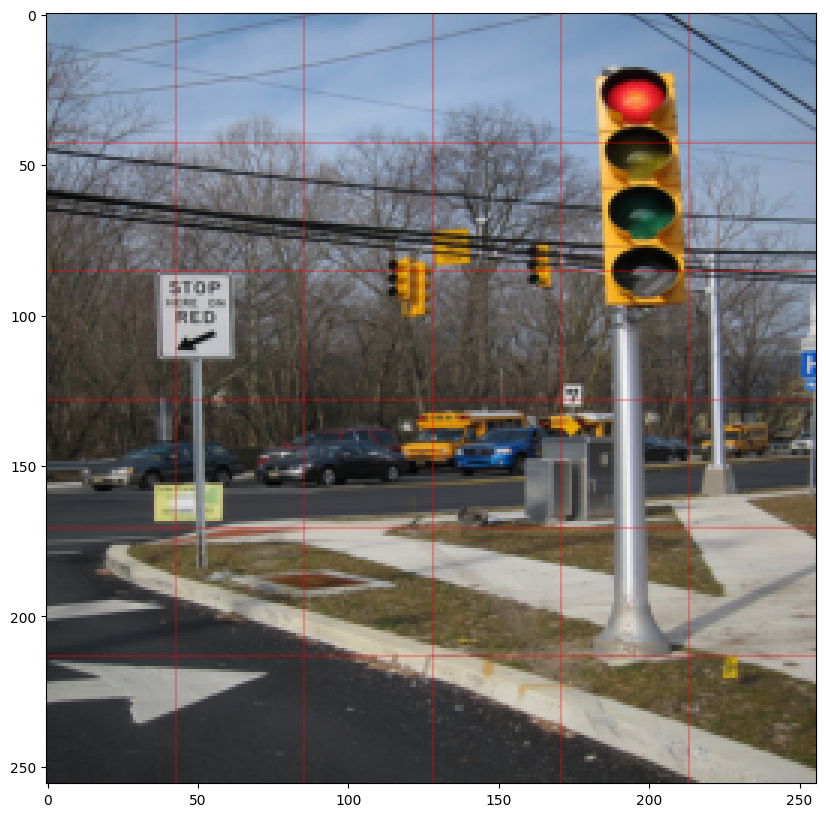

In [15]:
# Draw a random validation image with only ground truth boxes
idx = random.randint(0, len(val_dataset) - 1)
img, target = val_dataset[idx]
visualize_bbox(img, target)

## Training Loop

In [16]:
EPOCHS = 100
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

In [17]:
# Initialize model
model = BBoxModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = bbox_loss

c:\Users\patry\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patry\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
wandb_config = {
    "epochs": EPOCHS,
    "learning_rate": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
    "batch_size": BATCH_SIZE,
    "train_size": len(train_dataset),
    "val_size": len(val_subset),
    "test_size": len(test_subset),
    "grid_rows": GRID_ROWS,
    "grid_cols": GRID_COLS,
    "max_boxes_per_cell": MAX_BOXES_PER_CELL,
    "device": device,
    "image_size": IMAGE_SIZE,    
    "criterion": CRITERION_NAME,
    "optimizer": "Adam",
    "model_name": MODEL_NAME,
}

wandb.init(
    entity="fejowo5522-",
    project="NN_Project",
    config=wandb_config,
    group="BBoxDetection"
)


wandb: Currently logged in as: fejowo5522 (fejowo5522-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [19]:
verbose_tqdm = True

early_stopping = True
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
val_losses = []

In [20]:
for epoch in tqdm(range(EPOCHS)):
    # Train
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, verbose_tqdm=verbose_tqdm)
    train_losses.append(train_loss)
    
    # # Validate
    # val_loss = evaluate(model, val_loader, criterion, verbose_tqdm=verbose_tqdm)
    # val_losses.append(val_loss)
    
    # # Log to wandb
    # wandb.log({
    #     'epoch': epoch + 1,
    #     'train_loss': train_loss,
    #     'val_loss': val_loss
    # })

    pred_boxes = []
    true_boxes = []

    model.eval()
    for imgs, targets in val_loader:
        imgs = imgs.to(device)
        preds = model(imgs).cpu()
        
        pred_batch = decode_predictions(preds)
        pred_boxes.extend(pred_batch)
        
        for t in targets:
            gt_boxes = []
            for i in range(GRID_ROWS):
                for j in range(GRID_COLS):
                    for k in range(MAX_BOXES_PER_CELL):
                        if t[i, j, k, 4] == 1:
                            x_cell, y_cell, w, h = t[i, j, k, :4]
                            cell_w = IMAGE_SIZE[0] / GRID_COLS
                            cell_h = IMAGE_SIZE[1] / GRID_ROWS
                            x_center = j * cell_w + x_cell * cell_w
                            y_center = i * cell_h + y_cell * cell_h
                            width = w * IMAGE_SIZE[0]
                            height = h * IMAGE_SIZE[1]
                            x1 = x_center - width / 2
                            y1 = y_center - height / 2
                            x2 = x_center + width / 2
                            y2 = y_center + height / 2
                            gt_boxes.append((x1, y1, x2, y2))
            true_boxes.append(gt_boxes)

    precision, recall, f1 = calculate_map(pred_boxes, true_boxes)
    wandb.log({'epoch': epoch + 1, 'precision': precision, 'recall': recall, 'f1': f1})

    
    # Early stopping
    # if early_stopping:
    #     if val_loss < best_val_loss:
    #         best_val_loss = val_loss
    #         epochs_no_improve = 0
    #         torch.save(model.state_dict(), "best_model.pth")
    #     else:
    #         epochs_no_improve += 1
        
    #     if epochs_no_improve >= patience:
    #         print(f"Early stopping at epoch {epoch+1}")
    #         break


  0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/370 [00:00<?, ?it/s]

In [21]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))

# Evaluate on test set
model.eval()
test_loss = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")

# Log test results
wandb.log({'test_loss': test_loss})
wandb.finish()

# Save final model
torch.save(model.state_dict(), "bbox_model.pth")
print("Model saved to bbox_model.pth")


Test Loss: 5.1198


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
f1,▄▅▅▇▆█▅▇▇▆▅▆▅▄▄▇▅▆▆▅▆▅█▇▇▄▅▅▅▄▅▄▄▁▆▅▅▄▅▃
precision,▆▄▇▄▄▇▆▇▅▆▆▁▄▄▄▄▁▃▃▃█▅▆▄▃▅▆▅▇▄▄▅▅▄▅▅▃▅▃▃
recall,▃▅▅▄█▆▅▅▅▆▅▅▅▅▅▅▃▅▃▅▄▅▅▄▅▆▅▆▆▆▅▅▃▃▃▂▁▄▃▅
test_loss,▁
epoch,100
f1,0.09477
precision,0.14646
recall,0.07005
test_loss,5.11984


Model saved to bbox_model.pth


## Result evaluation and visualization

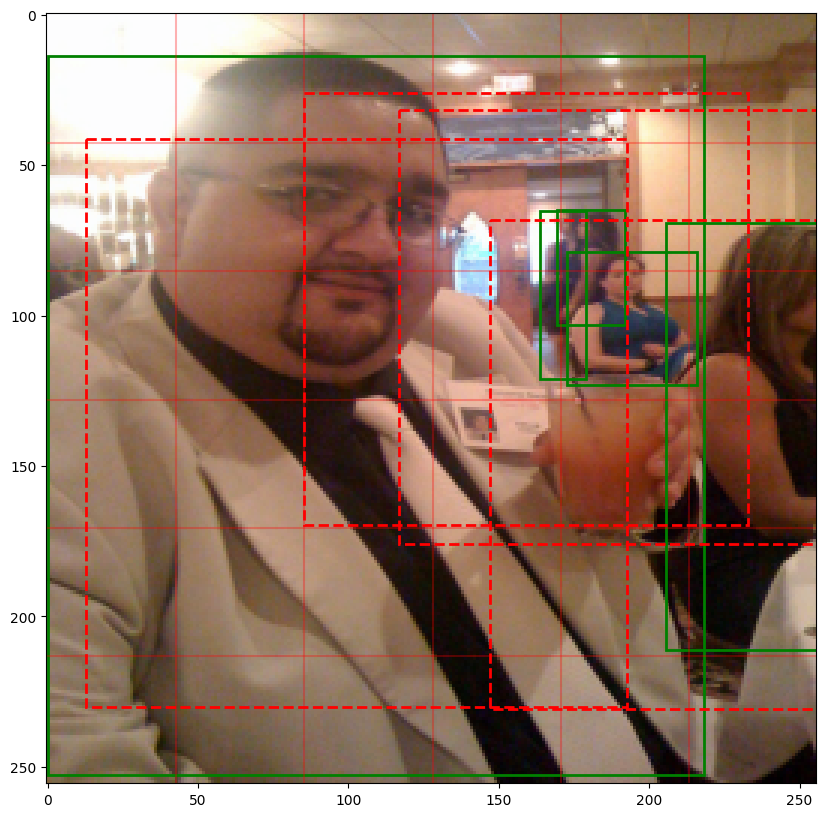

In [22]:
model.eval()
img, target = next(iter(val_loader))
with torch.no_grad():
    pred = model(img.to(device))[0].cpu()
    
visualize_bbox(img[0], target[0], pred)